# Amplitude Source Location

## 1. Introduction
In summer 1996, I was fortunate enough as a graduate student to be asked to assist the British Geological Survey in its monitoring of the Soufriere Hills Volcano, Montserrat. As part of "Team Seismic" at the Montserrat Volcano Observatory, our job was to provide 24-7 monitoring of the lava dome eruption, which had been continuous since October 1995. Crucially, this involved two-way radio communications with others working on the slopes of the volcano, and warning them of seismicity, especially pyroclastic flows [Add video here from Lauren's Journeys program]. 

I had the idea that we could use the RSAM data to locate seismicity continuously, on a map on a monitor in the Ops Room. I created a proof-of-concept, using the 60-s RSAM data (the 2.56-s RSAM data wasn't captured), and applying calibration constants. We'll replicate that here, but use DSAM data, which has already been instrument-corrected.

First, we will run some simulations, generating synthetic DSAM data for known locations, to test that it works.

## 2. Synthetic testing

### 2.1 Setup
We need to import the following, to set things up.

In [1]:
import os
import sys
import numpy as np
import obspy
from obspy import read_inventory
sys.path.append('../lib')
import setup_paths
paths = setup_paths.paths
from SAM import DSAM
from ASL import montserrat_topo_map, Grid, ASL, simulate_DSAM

### 2.1 Map of Montserrat stations
Seismic stations with a vertical-component sensor, operational (though not necessarily working properly) on July 12, 2003.

In [2]:
invMVO = read_inventory(os.path.join(paths['RESPONSE_DIR'],'MV.xml'), format='stationxml')
startt = obspy.UTCDateTime(2003,7,12,23,0,0)
endt = obspy.UTCDateTime(2003,7,13,4,0,0)
invMVO = invMVO.select(starttime=startt, endtime=endt)
invMVO = invMVO.select(channel='*Z')
#montserrat_topo_map(inv=invMVO, show=True, add_labels=True);

### 2.2 Define a grid of source locations and reduced displacement at those nodes

In [3]:
#synth_source = {'lat':16.71111, 'lon':-62.17722, 'max_DR':100.0, 'starttime':startt, 'npts':100, 'sampling_interval':60.0}
sampling_interval = 60
synthetic_source = {}
synthetic_source['lat'] = 16.71111 + np.tile(np.arange(5)/1000, 5)
synthetic_source['lon'] = -62.17722 + np.repeat(np.arange(5)/1000, 5)
N = len(synthetic_source['lat'])
synthetic_source['DR'] = np.ones(N) * 100.0 # 100 cm^2 everywhere
synthetic_source['t'] = [obspy.UTCDateTime(0) + t * sampling_interval for t in range(N)]
print(synthetic_source)

{'lat': array([16.71111, 16.71211, 16.71311, 16.71411, 16.71511, 16.71111,
       16.71211, 16.71311, 16.71411, 16.71511, 16.71111, 16.71211,
       16.71311, 16.71411, 16.71511, 16.71111, 16.71211, 16.71311,
       16.71411, 16.71511, 16.71111, 16.71211, 16.71311, 16.71411,
       16.71511]), 'lon': array([-62.17722, -62.17722, -62.17722, -62.17722, -62.17722, -62.17622,
       -62.17622, -62.17622, -62.17622, -62.17622, -62.17522, -62.17522,
       -62.17522, -62.17522, -62.17522, -62.17422, -62.17422, -62.17422,
       -62.17422, -62.17422, -62.17322, -62.17322, -62.17322, -62.17322,
       -62.17322]), 'DR': array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100.]), 't': [UTCDateTime(1970, 1, 1, 0, 0), UTCDateTime(1970, 1, 1, 0, 1), UTCDateTime(1970, 1, 1, 0, 2), UTCDateTime(1970, 1, 1, 0, 3), UTCDateTime(1970, 1, 1, 0, 4), UTCDateTime(1970, 1, 1, 0, 5), UTCDateTime(197

DSAM
METRIC:  mean


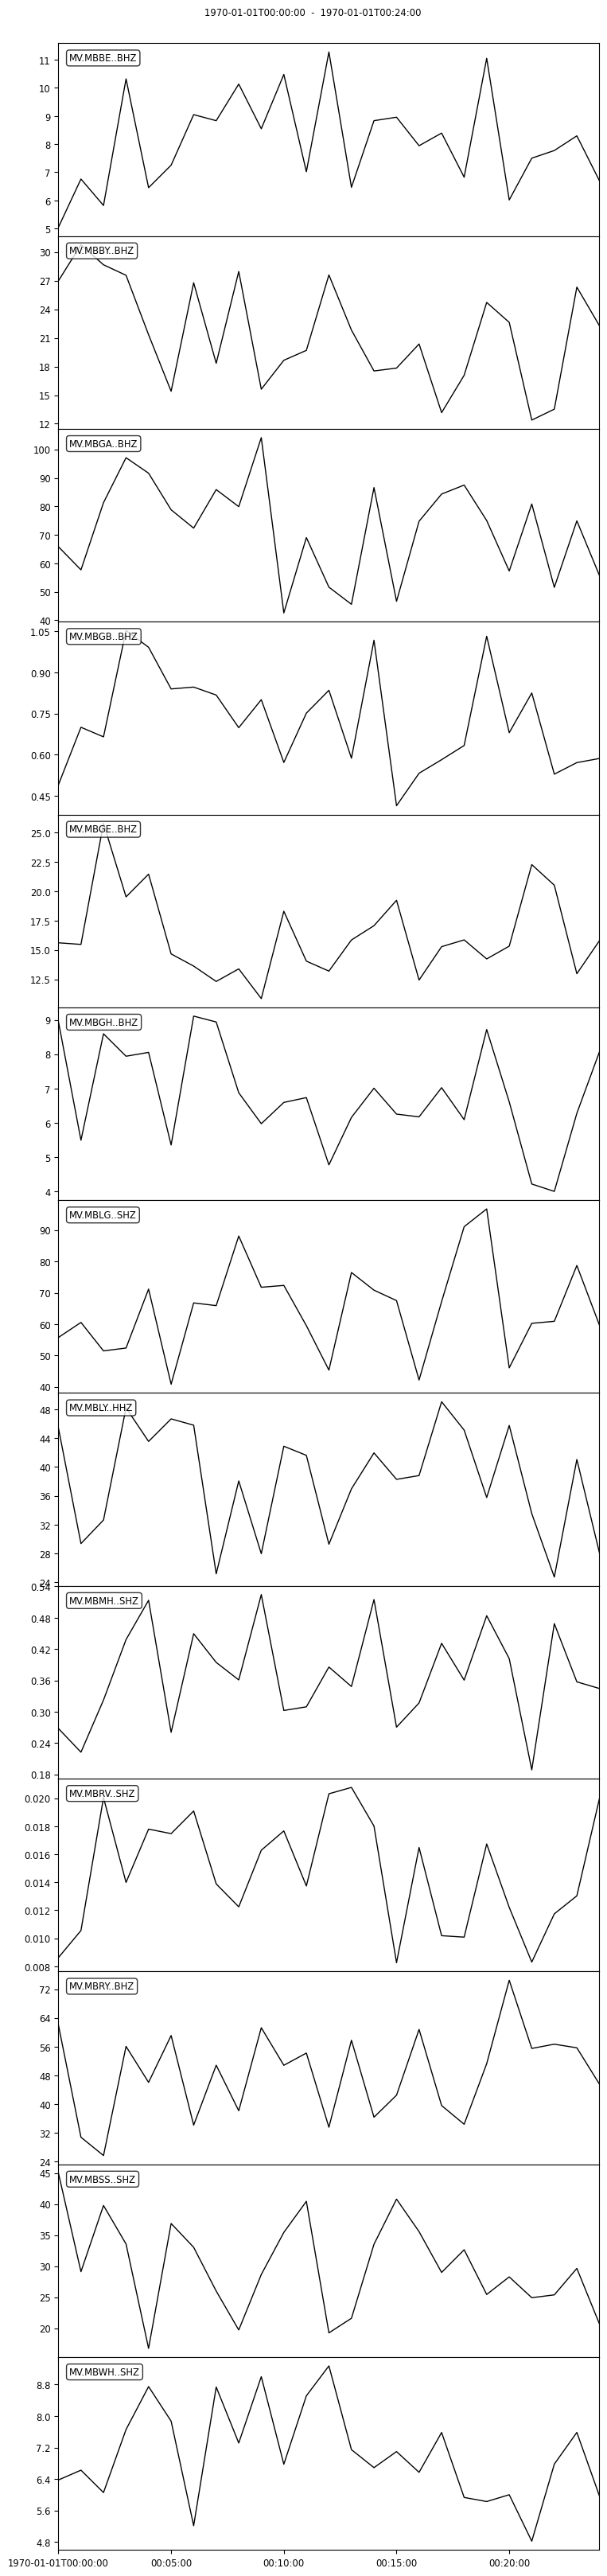

In [4]:
surfaceWaveSpeed_kms = 1.5
peakf=8.0
Q=23
synthDSAMobj = simulate_DSAM(invMVO, synthetic_source, surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, \
                             peakf=peakf, Q=Q, noise_level_percent=20.0)
synthDSAMobj.plot(metrics='mean')

### 2.3 Create grid 

In [6]:
node_spacing_m = 100
grid_size_lat_m = 10000
grid_size_lon_m = 8000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(synthetic_source['lat'][0], synthetic_source['lon'][0], nlat, nlon, node_spacing_m)  
#gridobj.plot(node_spacing_m = node_spacing_m)

In [7]:
aslobj = ASL(synthDSAMobj, 'mean', invMVO, gridobj)

In [8]:
aslobj.compute_grid_distances()

In [9]:
aslobj.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=Q, fix_peakf=peakf)

In [10]:
source = aslobj.fast_locate()

1859131483.221284
1.0


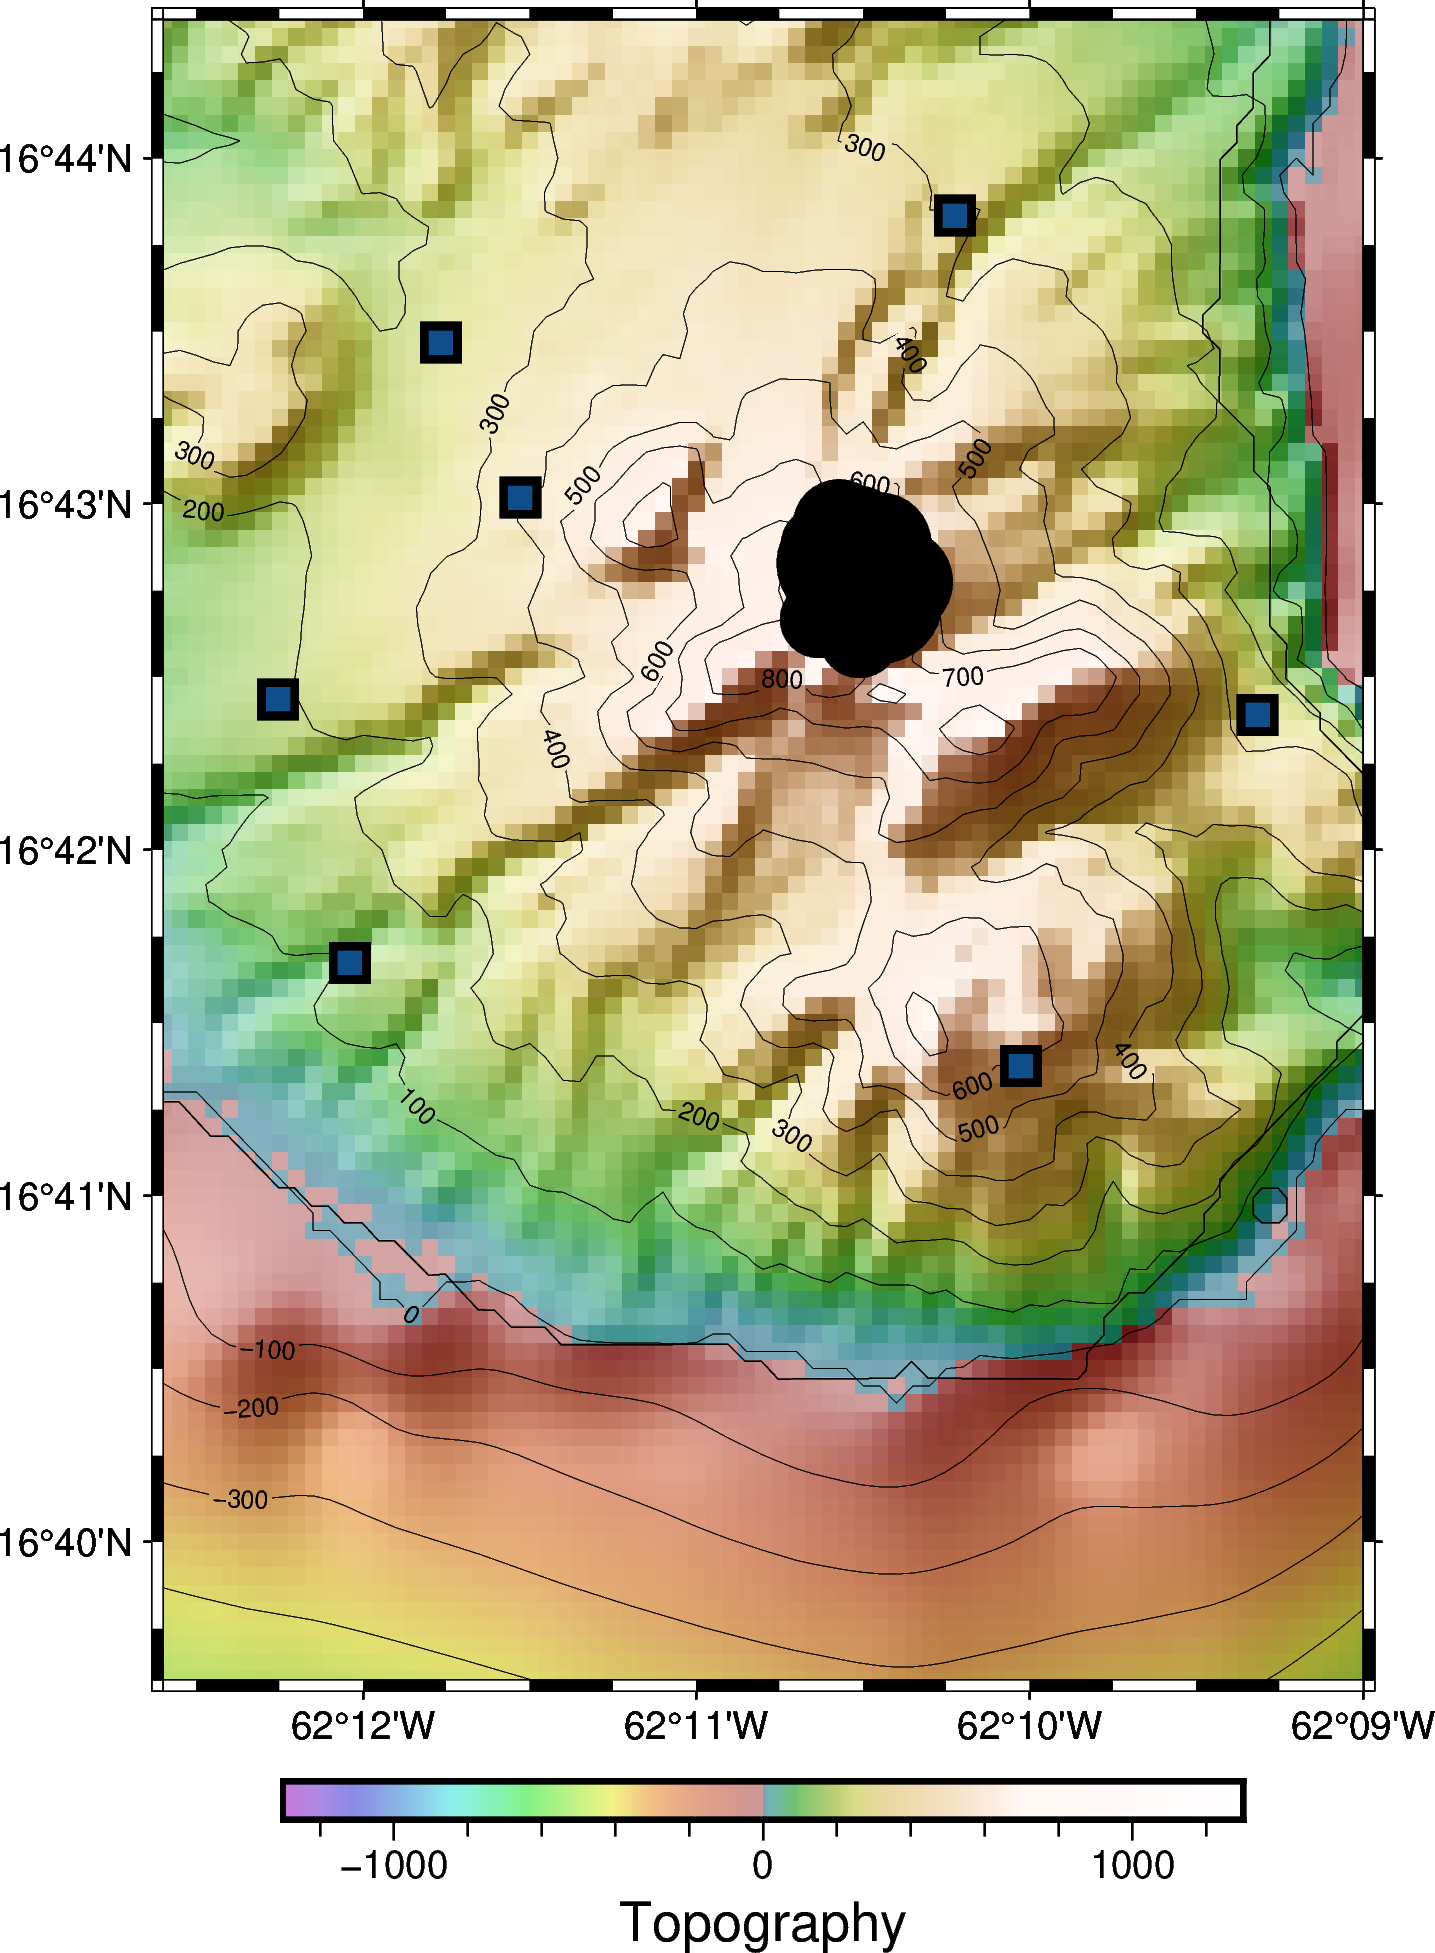

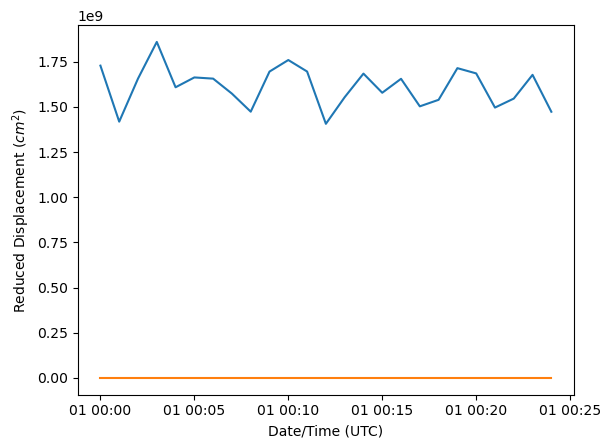

In [11]:
aslobj.plot(source, cross_scale=1e2, zoom_level=2, threshold_DR=1.0, scale=1e-2)

## 3 Using real DSAM data: July 12, 2003 collapse

Read inventory and DSAM data. Plot DSAM data

In [ ]:
invMVO = read_inventory(os.path.join(paths['RESPONSE_DIR'],'MV.xml'), format='stationxml')
#invMVO.plot(projection='local', resolution='f');
startt = obspy.UTCDateTime(2003,7,12,23,0,0)
endt = obspy.UTCDateTime(2003,7,13,4,0,0)
dsamObj = DSAM.read(startt, endt, SAM_DIR=paths['SAM_DIR'], sampling_interval=60, ext='pickle', \
                     trace_ids=['MV.MBGH..BHZ', 'MV.MBLG..SHZ', 'MV.MBRY..BHZ', 'MV.MBSS..SHZ', 'MV.MBWH..SHZ'])  

dsamObj.plot(metrics='VT')

Create an initial grid and plot it

In [ ]:
source = {'lat':16.71111, 'lon':-62.17722}
node_spacing_m = 20
grid_size_lat_m = 10000
grid_size_lon_m = 8000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  
gridobj.plot(node_spacing_m = node_spacing_m)

Create ASL object, compute distances from each station to each node, compute corresponding amplitude corrections from each station to each node

In [ ]:
Q = 23
surfaceWaveSpeed_kms = 1.5 # km/s
peakf = 8.0

aslobj = ASL(dsamObj, 'rms', invMVO, gridobj)

aslobj.compute_grid_distances()

aslobj.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=Q, fix_peakf = peakf)

Run the amplitude location

In [ ]:
source = aslobj.fast_locate()

Plot locations

In [ ]:
aslobj.plot(source, cross_scale=1e2, zoom_level=2, threshold_DR=500.0, scale=1e-2)

In [ ]:
# do a simulation test here